In [28]:
import numpy as np
import matplotlib.pyplot as plt

Equations:

$Y = H \times X + B$

$\begin{pmatrix}
u \\
\alpha_M \\
\end{pmatrix} = 
\begin{pmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
\end{pmatrix} .
\begin{pmatrix}
\dot{\alpha} \\
\alpha \\
b \\
\end{pmatrix} +
\begin{pmatrix}
b_1 \\
b_2 \\
\end{pmatrix}$

Y: mesures - $\alpha_M$: angle d'inclinaison - u: vitesse angulaire

X: valeurs réelles

H: matrice d'observation

B: Bruit de mesures - $b_1$: bruit accèléromètre - $b_2$: bruit gyroscope




In [29]:
# Generate real data
T_max = 10 # seconds
T_step = 0.1
bias = 5
s1_noise = 0.1    # gyroscope var
s2_noise = 0.1    # accelerometre var
e_angular_speed = 10.0
e_position = 0.0
e_bias = 2.0

T = np.arange(0, T_max, T_step)
X_real = np.zeros((3, len(T)))

# Angular speed
X_real[0,:] = 5 * np.sin(2 * np.pi * T)
# Angular position
for i in range(1,len(T)):
    X_real[1, i] = X_real[1, i-1] + T_step * X_real[0, i-1]
# Bias
# X_real[2,:] = np.ones((1, len(T))) * bias
X_real[2,:] = np.exp(T/bias) * bias


In [30]:
# Generate measures
Y = np.zeros((2, X_real.shape[1])) #+ np.random.normal(0, 1, X_real.shape)
Y[0,:] = X_real[0,:] + X_real[2,:] + np.random.normal(0, s1_noise, X_real[0,:].shape)
Y[1,:] = X_real[1,:] + np.random.normal(0, s2_noise, X_real[1,:].shape)

Modèle:

$X_{k+1} = A.X_k$

$\begin{pmatrix} \dot{\alpha} \\ \alpha \\ b \\ \end{pmatrix}_{k+1}=
\begin{pmatrix} 1 & 0 & 0 \\ t_e & 1 & 0 \\ 0 & 0 & 1 \\ \end{pmatrix}.
\begin{pmatrix} \dot{\alpha} \\ \alpha_M \\ u \\ \end{pmatrix}_{k}$


Matrice de covariance du bruit de mesure:

$R=\begin{pmatrix} \sigma_1^2 & 0 \\ 0 & \sigma_2^2 \\ \end{pmatrix}$

Matrice de covariance du bruit de commande: (erreurs de modélisation du système)

$Q=\begin{pmatrix} \epsilon_\dot{\alpha} & 0 & 0 \\ 0 & \epsilon_\alpha & 0 \\ 0 & 0 & \epsilon_b \end{pmatrix}$

Phase de prédiction:

$\hat{X}_{k+1}^+ = A.\hat{X}_k$

$P_k^+=A.P_k.A^T+Q$

Phase de mise à jour:

$K_{k+1}=P_k^+.h_{k+1}^T.(R_{k+1}+h_{k+1}.P_k^+.h_{k+1}^T)^{-1}$

$P_{k+1}=(I-K_{k+1}.h_{k+1}).P_k^+$

$\hat{X}_{k+1}=\hat{X}_k^++K_{k+1}.(y_{k+1}-h_{k+1}.\hat{X}_k^+)$


In [31]:
# Kalman filter variables
X_pred = np.zeros((X_real.shape[0], X_real.shape[1] + 1))
X_est = np.zeros(X_real.shape)
X_est[:,0] = X_real[:,0]

# Covariance matrix of the estamed state
P = np.zeros((3, 3))
P_pred = np.zeros((3, 3))    # prediction of P

# Observation matrix
H = np.array([[1, 0, 1], [0, 1, 0]])

# Sensor noise
R = np.array([[s1_noise**2, 0], [0, s2_noise**2]])
                  
# Model
A = np.array([[1, 0, 0], [T_step, 1, 0], [0, 0, 1]])
                  
# Modele error
Q = np.array([[e_angular_speed, 0, 0], [0, e_position, 0], [0, 0, e_bias]])

# Main loop
for i, t in enumerate(T):
    if i == 0:
        continue
    # Prediction
    X_pred[:,i] = A.dot(X_est[:,i-1])
    P_pred = A.dot(P).dot(A.T) + Q
    
    # Update
    K = P_pred.dot(H.T).dot(np.linalg.inv(R + H.dot(P_pred).dot(H.T)))
    P = (np.identity(3) - K.dot(H)).dot(P_pred)
    X_est[:,i] = X_pred[:,i] + K.dot(Y[:,i] - H.dot(X_pred[:,i]))

print("OK")
                  

OK


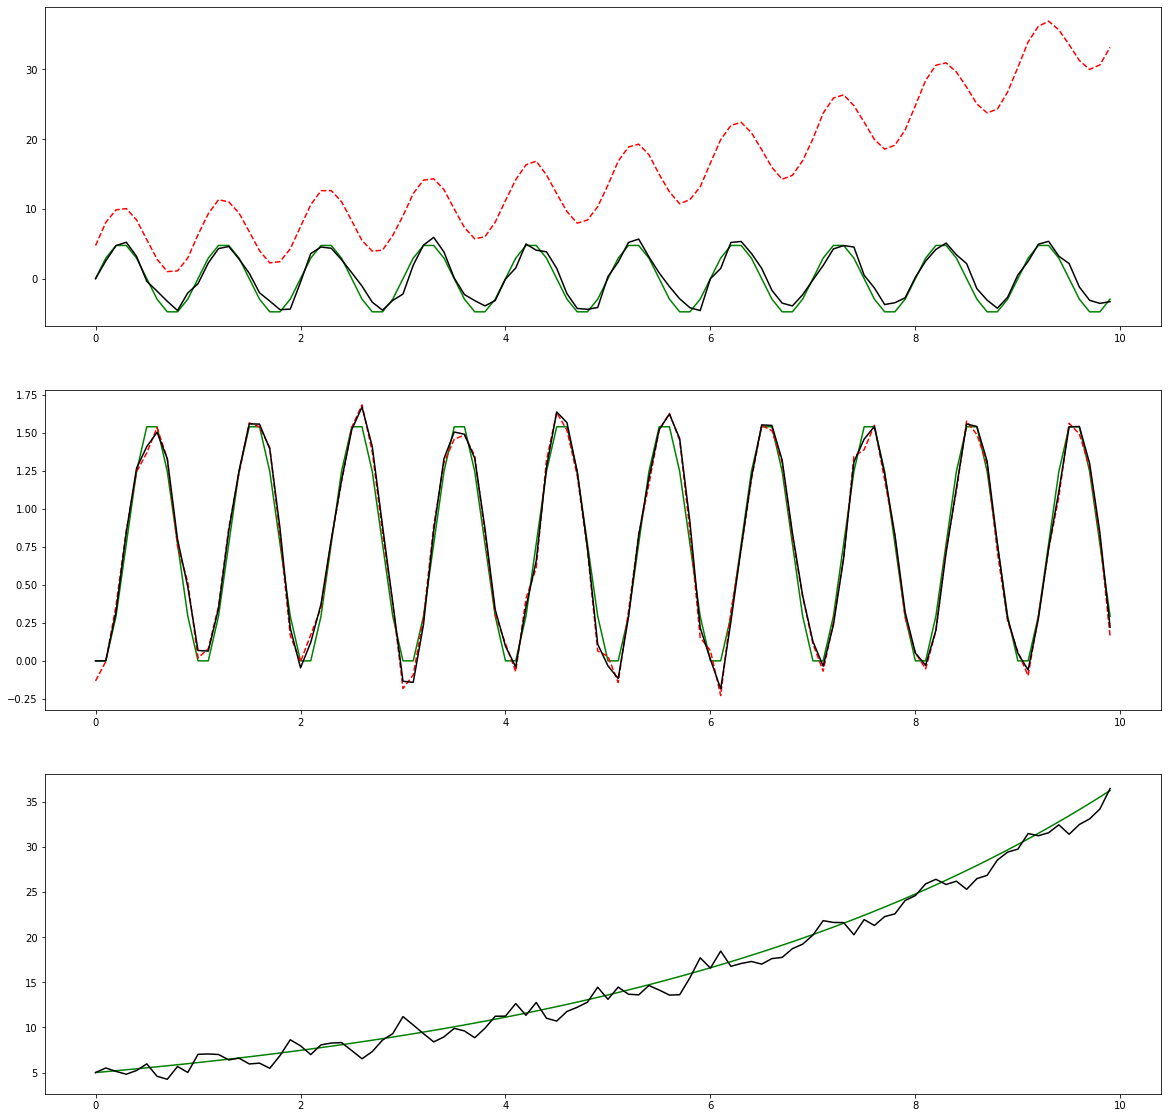

In [32]:
plt.rcParams["figure.figsize"] = (20, 20)

# Plot angular speed
plt.subplot(3,1,1)
plt.plot(T, X_real[0,:], 'g')
plt.plot(T, Y[0,:], 'r--')
plt.plot(T, X_est[0,:], 'k')

# Plot angular position
plt.subplot(3,1,2)
plt.plot(T, X_real[1,:], 'g')
plt.plot(T, Y[1,:], 'r--')
plt.plot(T, X_est[1,:], 'k')

# Plot bias
plt.subplot(3,1,3)
plt.plot(T, X_real[2,:], 'g')
# plt.plot(T, Y[2,:], 'r--')
plt.plot(T, X_est[2,:], 'k')

plt.show()